In [1]:
import pandas as pd
import numpy as np

import featuretools as ft
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import os

# Get the Dataset

In [2]:
flight_weather = pd.read_csv('./flight_weather.csv').reset_index()
flight_weather = flight_weather.drop('Unnamed: 0', axis=1)
flight_weather = flight_weather.drop_duplicates()
flight_weather.shape

(36407, 98)

In [3]:
flight_weather.columns

Index(['index', 'flight_date', 'flight_status', 'departure_airport',
       'departure_timezone', 'departure_iata', 'departure_icao',
       'departure_gate', 'departure_delay', 'departure_scheduled',
       'departure_estimated', 'departure_actual', 'departure_estimated_runway',
       'departure_actual_runway', 'arrival_airport', 'arrival_timezone',
       'arrival_iata', 'arrival_icao', 'arrival_terminal', 'arrival_scheduled',
       'arrival_estimated', 'arrival_actual', 'arrival_estimated_runway',
       'arrival_actual_runway', 'airline_name', 'airline_iata', 'airline_icao',
       'flight_number', 'flight_iata', 'flight_icao', 'rh_departure',
       'max_wind_spd_ts_departure', 't_ghi_departure',
       'max_wind_spd_departure', 'solar_rad_departure',
       'wind_gust_spd_departure', 'max_temp_ts_departure',
       'min_temp_ts_departure', 'clouds_departure', 'max_dni_departure',
       'precip_gpm_departure', 'wind_spd_departure', 'slp_departure',
       'ts_departure', 'max_g

In [4]:
len(flight_weather.columns)

98

In [5]:
# len(flight_weather['airline_name'].unique())
num_flights = flight_weather.groupby(by=["departure_iata", "arrival_iata"]).count()['flight_number']
num_flights = num_flights.sort_values(ascending=False)
num_flights.head(10)

departure_iata  arrival_iata
DFW             ABI             342
ATL             FAY             304
ACT             DFW             304
ATL             MLU             304
DFW             ACT             304
ABI             DFW             228
ATL             BOS             196
DFW             FAY             190
FAY             ATL             190
CGK             DPS             172
Name: flight_number, dtype: int64

# Feature engineering

In [6]:
# feature_tools selection

def load_entityset(flight_weather):
    # return the EntitySet object
    dataframes = {
    "flight_weather" : (flight_weather, 'index')
    }
    
    relationships = []

    return ft.EntitySet("my-entity-set", dataframes, relationships)

In [7]:
es = load_entityset(flight_weather)
# use ft.dfs to perform feature engineering
feature_matrix, feature_defs = ft.dfs(entityset=es, entities=es, target_entity="flight_weather")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/featuretools/synthesis/deep_feature_synthesis.py:156: UserWarning: Only one entity in entityset, changing max_depth to 1 since deeper features cannot be created
  warnings.warn("Only one entity in entityset, changing max_depth to "


In [8]:
feature_matrix

,flight_status,departure_airport,departure_timezone,departure_iata,departure_icao,departure_gate,departure_delay,arrival_airport,arrival_timezone,arrival_iata,...,YEAR(arrival_estimated_runway),YEAR(arrival_scheduled),YEAR(datetime_arrival),YEAR(datetime_departure),YEAR(departure_actual),YEAR(departure_actual_runway),YEAR(departure_estimated),YEAR(departure_estimated_runway),YEAR(departure_scheduled),YEAR(flight_date)
index,,,,,,,,,,,,,,,,,,,,,
0,landed,Schiphol,Europe/Amsterdam,AMS,EHAM,B15,10.0,Findel,Europe/Luxembourg,LUX,...,2021.0,2021,2021,2021,2021.0,2021.0,2021,2021.0,2021,2021
1,landed,Schiphol,Europe/Amsterdam,AMS,EHAM,B15,10.0,Findel,Europe/Luxembourg,LUX,...,2021.0,2021,2021,2021,2021.0,2021.0,2021,2021.0,2021,2021
2,landed,Schiphol,Europe/Amsterdam,AMS,EHAM,B15,10.0,Findel,Europe/Luxembourg,LUX,...,2021.0,2021,2021,2021,2021.0,2021.0,2021,2021.0,2021,2021
3,landed,Schiphol,Europe/Amsterdam,AMS,EHAM,B15,10.0,Findel,Europe/Luxembourg,LUX,...,2021.0,2021,2021,2021,2021.0,2021.0,2021,2021.0,2021,2021
4,landed,Schiphol,Europe/Amsterdam,AMS,EHAM,B15,10.0,Findel,Europe/Luxembourg,LUX,...,2021.0,2021,2021,2021,2021.0,2021.0,2021,2021.0,2021,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36402,landed,Zurich,Europe/Zurich,ZRH,LSZH,A83,15.0,Franz Josef Strauss,Europe/Berlin,MUC,...,2022.0,2022,2022,2022,2022.0,2022.0,2022,2022.0,2022,2022
36403,landed,Zurich,Europe/Zurich,ZRH,LSZH,1,17.0,Arlanda,Europe/Stockholm,ARN,...,2022.0,2022,2022,2022,2022.0,2022.0,2022,2022.0,2022,2022
36404,landed,Zurich,Europe/Zurich,ZRH,LSZH,1,17.0,Arlanda,Europe/Stockholm,ARN,...,2022.0,2022,2022,2022,2022.0,2022.0,2022,2022.0,2022,2022


In [9]:
# Select best feaetures

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

feature_matrix_temp = feature_matrix.copy()
feature_matrix_temp = pd.DataFrame(feature_matrix_temp)
feature_matrix_temp = feature_matrix_temp.dropna(how='any', axis = 0)

for i in feature_matrix_temp.columns:
    if feature_matrix_temp[i].dtype == 'object':
        # feature_matrix_temp = feature_matrix_temp.drop(i, axis=1)
        encoder = LabelEncoder()
        feature_matrix_temp[i] = encoder.fit_transform(feature_matrix_temp[i])
    
    
feature_matrix_temp = feature_matrix_temp.fillna(0)
feature_matrix_temp.shape
y = feature_matrix_temp['flight_status']
X = feature_matrix_temp.drop(['flight_status'], axis=1)

sel = VarianceThreshold(threshold=(.6 * (1 - .6)))
feature_matrix_temp = sel.fit_transform(feature_matrix_temp)
#apply SelectKBest class to extract top 10 best features 
selector = SelectKBest(score_func=f_regression, k=10)
fit = selector.fit(X, y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns, dfscores],axis=1) 
featureScores.columns = ['Feature', 'Score']
featureScores = featureScores.sort_values(['Score'], axis = 0, ascending = False)
X = X.loc[:, featureScores['Feature'][:10].tolist()]
print(featureScores.nlargest(10,'Score'))
print(X.shape)

                                 Feature      Score
8                           arrival_iata  25.325424
9                           arrival_icao  25.322576
111           WEEKDAY(arrival_estimated)  22.004385
113           WEEKDAY(arrival_scheduled)  22.004385
116            WEEKDAY(departure_actual)  21.924415
117     WEEKDAY(departure_actual_runway)  21.924415
119  WEEKDAY(departure_estimated_runway)  21.924415
118         WEEKDAY(departure_estimated)  21.868802
120         WEEKDAY(departure_scheduled)  21.868802
114            WEEKDAY(datetime_arrival)  21.868802
(3179, 10)


In [10]:
#add flight_status

feature_list = featureScores['Feature'][:20].tolist()
feature_list.append('flight_status')
print(feature_list)

['arrival_iata', 'arrival_icao', 'WEEKDAY(arrival_estimated)', 'WEEKDAY(arrival_scheduled)', 'WEEKDAY(departure_actual)', 'WEEKDAY(departure_actual_runway)', 'WEEKDAY(departure_estimated_runway)', 'WEEKDAY(departure_estimated)', 'WEEKDAY(departure_scheduled)', 'WEEKDAY(datetime_arrival)', 'WEEKDAY(datetime_departure)', 'WEEKDAY(flight_date)', 'WEEKDAY(arrival_estimated_runway)', 'WEEKDAY(arrival_actual_runway)', 'WEEKDAY(arrival_actual)', 'arrival_timezone', 'rh_departure', 'temp_arrival', 'clouds_departure', 'min_temp_arrival', 'flight_status']


In [11]:
df = feature_matrix[feature_list]
df.columns

Index(['arrival_iata', 'arrival_icao', 'WEEKDAY(arrival_estimated)',
       'WEEKDAY(arrival_scheduled)', 'WEEKDAY(departure_actual)',
       'WEEKDAY(departure_actual_runway)',
       'WEEKDAY(departure_estimated_runway)', 'WEEKDAY(departure_estimated)',
       'WEEKDAY(departure_scheduled)', 'WEEKDAY(datetime_arrival)',
       'WEEKDAY(datetime_departure)', 'WEEKDAY(flight_date)',
       'WEEKDAY(arrival_estimated_runway)', 'WEEKDAY(arrival_actual_runway)',
       'WEEKDAY(arrival_actual)', 'arrival_timezone', 'rh_departure',
       'temp_arrival', 'clouds_departure', 'min_temp_arrival',
       'flight_status'],
      dtype='object')

In [12]:
# check null value
df.isnull().sum()

arrival_iata                               0
arrival_icao                               0
WEEKDAY(arrival_estimated)                 0
WEEKDAY(arrival_scheduled)                 0
WEEKDAY(departure_actual)               6134
WEEKDAY(departure_actual_runway)        6134
WEEKDAY(departure_estimated_runway)     6134
WEEKDAY(departure_estimated)               0
WEEKDAY(departure_scheduled)               0
WEEKDAY(datetime_arrival)                  0
WEEKDAY(datetime_departure)                0
WEEKDAY(flight_date)                       0
WEEKDAY(arrival_estimated_runway)      10873
WEEKDAY(arrival_actual_runway)         10873
WEEKDAY(arrival_actual)                10873
arrival_timezone                           0
rh_departure                               0
temp_arrival                               0
clouds_departure                           0
min_temp_arrival                           0
flight_status                             57
dtype: int64

In [13]:
#fill NaN value
df = df.fillna(method='backfill', axis=0, inplace=False)

In [14]:
# re-check null value
df.isnull().sum()

arrival_iata                           0
arrival_icao                           0
WEEKDAY(arrival_estimated)             0
WEEKDAY(arrival_scheduled)             0
WEEKDAY(departure_actual)              0
WEEKDAY(departure_actual_runway)       0
WEEKDAY(departure_estimated_runway)    0
WEEKDAY(departure_estimated)           0
WEEKDAY(departure_scheduled)           0
WEEKDAY(datetime_arrival)              0
WEEKDAY(datetime_departure)            0
WEEKDAY(flight_date)                   0
WEEKDAY(arrival_estimated_runway)      0
WEEKDAY(arrival_actual_runway)         0
WEEKDAY(arrival_actual)                0
arrival_timezone                       0
rh_departure                           0
temp_arrival                           0
clouds_departure                       0
min_temp_arrival                       0
flight_status                          0
dtype: int64

# Model to do flight status classification

In [15]:
df.hist(figsize=(40,40));

In [16]:
# encoder flight_status from 0 - 5
df['status_label'] = df['flight_status']\
    .map(lambda x: 0 if x=="landed" else 1 if x=="scheduled" else 2 if x=="active" else 3 if x=="cancelled" else 4 if x =="diverted" else 5)

In [17]:
df = df.drop(['arrival_timezone', 'arrival_iata', 'arrival_icao'], axis = 1)

In [18]:
# six flight status

df_list = []
status = df['flight_status'].unique()
for i in status:
    new_df = pd.DataFrame()
    new_df = df[df['flight_status'] == i]
    df_list.append(new_df)

In [19]:
# Split train / test dataset based on fixed fac for all six labels

test = pd.DataFrame()             
train = pd.DataFrame()            

for i in df_list:
    sample = i.sample(int(0.2*len(i)))
    sample_index = sample.index
    
    all_index = i.index
    residue_index = all_index.difference(sample_index)
    residue = i.loc[residue_index]

    test = pd.concat([test, sample], ignore_index=True)
    train = pd.concat([train, residue], ignore_index=True)
if 'flight_status' in train.columns:
    train = train.drop('flight_status', axis=1)
if 'flight_status' in test.columns: 
    test = test.drop('flight_status', axis=1)

In [20]:
accuracy_score = {}
f1_scores = {}
# LogisticModel performance
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

lr = LogisticRegression()
train_X = train.iloc[:, :-1]
train_y = train.iloc[:, -1]
test_X = test.iloc[:, :-1]
test_y = test.iloc[:, -1]


lr.fit(train_X, train_y)
pred_y = lr.predict(test_X)


print('F1_score: ', f1_score(test_y, pred_y, average='micro'))
print("accuracy: ", metrics.accuracy_score(test_y, pred_y))
accuracy_score['logistic'] = metrics.accuracy_score(test_y, pred_y)
f1_scores['logistic'] = f1_score(test_y, pred_y, average='micro')

F1_score:  0.6986809563066777
accuracy:  0.6986809563066777


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


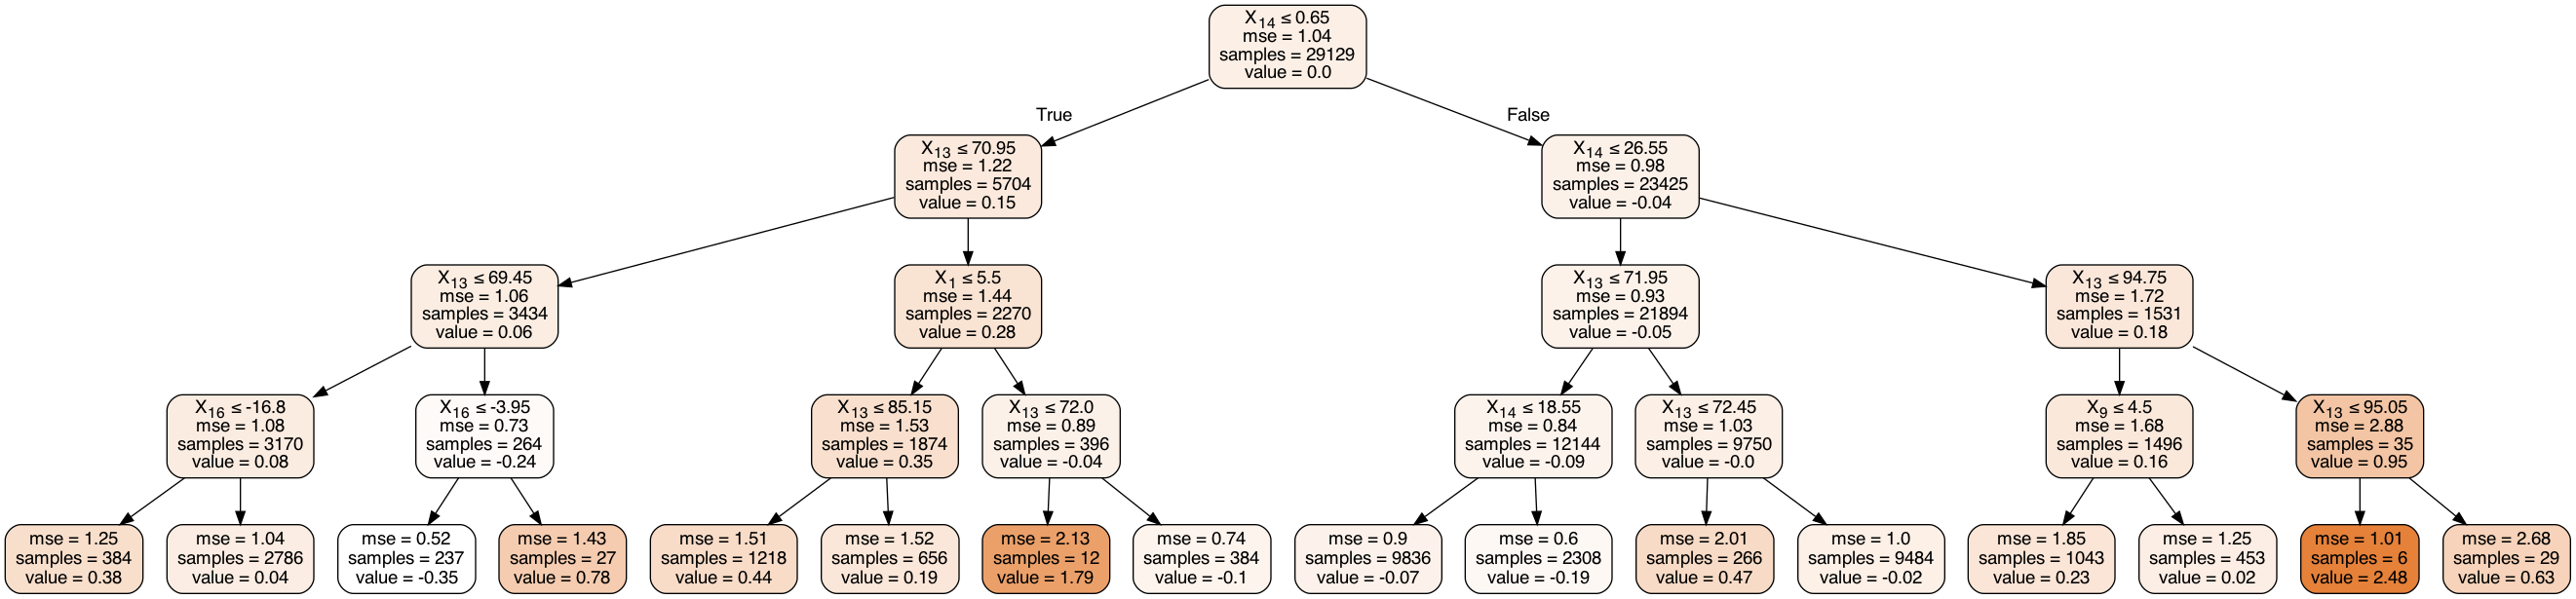

In [21]:
# GBDT Model
import pydotplus
from sklearn.ensemble import GradientBoostingRegressor
from IPython.display import Image  
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz


gbdt = GradientBoostingRegressor(max_depth=4, criterion ='mse').fit(train_X, train_y)
sub_tree = gbdt.estimators_[5, 0]
dot_data = export_graphviz(sub_tree, out_file=None, filled=True, rounded=True, special_characters=True, precision=2)
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [22]:
# GBDT Model
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

gbm0 = GradientBoostingClassifier(random_state=10)
gbm0.fit(train_X,train_y)
y_pred = gbm0.predict(test_X)
y_predprob = gbm0.predict_proba(test_X)[:,1]


print('F1_score: ', f1_score(test_y.values, pred_y, average='micro'))
print("Accuracy : %.4g" % metrics.accuracy_score(test_y.values, y_pred))
accuracy_score['GBDT'] = metrics.accuracy_score(test_y.values, y_pred)
f1_scores['GBDT'] = f1_score(test_y.values, pred_y, average='micro')

F1_score:  0.6986809563066777
Accuracy : 0.7208


In [23]:
# XGBoost
from xgboost import XGBClassifier
xgbc = XGBClassifier(max_depth=2, 
                     learning_rate=1, 
                     n_estimators=400, # number of iterations or number of trees
                     slient=0,
                     objective="binary:logistic"
                    )

xgbc.fit(train_X, train_y)
pred_train = xgbc.predict(train_X)
pred_train = [round(x) for x in pred_train]
train_score = metrics.accuracy_score(train_y, pred_train)
print("Train Accuracy: %.2f%%" % (train_score * 100))

pred_test = xgbc.predict(test_X)
pred_test = [1 if x >= 0.5 else 0 for x in pred_test]


print('F1_score: ', f1_score(test_y, pred_y, average='micro'))
print("Test Accuracy: %.2f%%" % (metrics.accuracy_score(test_y, pred_test)))
accuracy_score['XGBoost'] = metrics.accuracy_score(test_y, pred_test)

f1_scores['XGBoost'] = f1_score(test_y, pred_y, average='micro')

[14:03:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "slient" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:03:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Train Accuracy: 80.73%
F1_score:  0.6986809563066777
Test Accuracy: 0.72%


In [24]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn import svm

tscv = TimeSeriesSplit(n_splits=10)
clf_rf = RandomForestClassifier(n_estimators=800, n_jobs=-1)
clf_rf_scores = cross_val_score(estimator=clf_rf, X=train_X, y=train_y, cv=tscv, verbose=True)
clf_rf.fit(train_X, train_y)
clf_rf_pred = clf_rf.predict(test_X)

print("RandomForestClassifier AUC %.2f" % metrics.accuracy_score(test_y, clf_rf_pred))

print('F1_score: ', f1_score(test_y, clf_rf_pred, average='micro'))


accuracy_score['RandomForest'] = metrics.accuracy_score(test_y, clf_rf_pred)
f1_scores['RandomForest'] = metrics.accuracy_score(test_y, clf_rf_pred)
# print("SVM AUC %.2f" % (clf_svm_scores.mean()))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   28.0s finished


RandomForestClassifier AUC 0.88
F1_score:  0.8751030502885409


In [25]:
df = df.drop('flight_status', axis = 1)

# Plot result

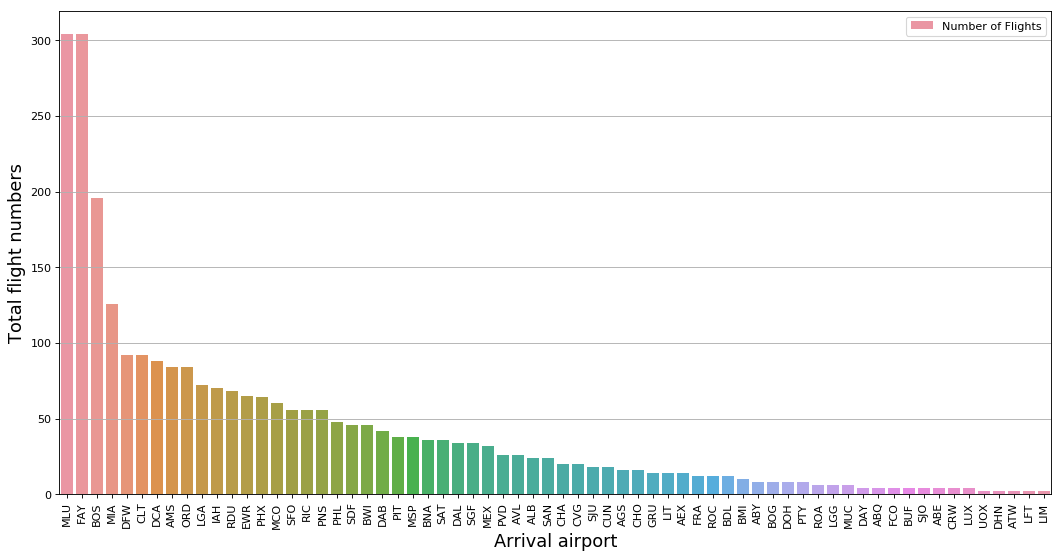

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


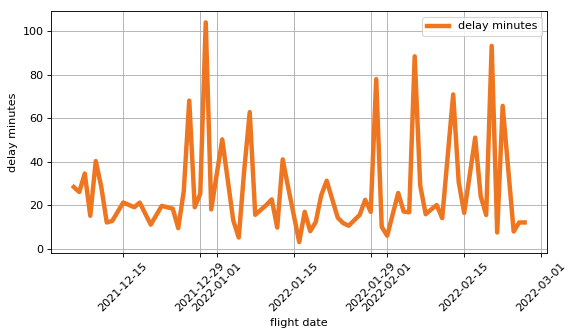

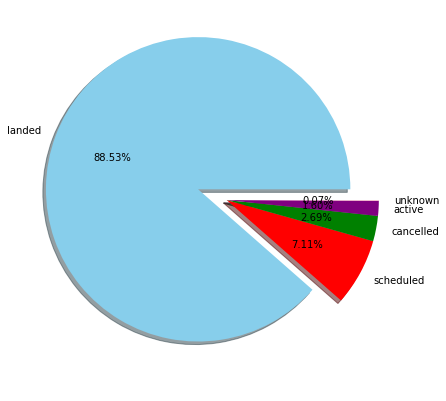

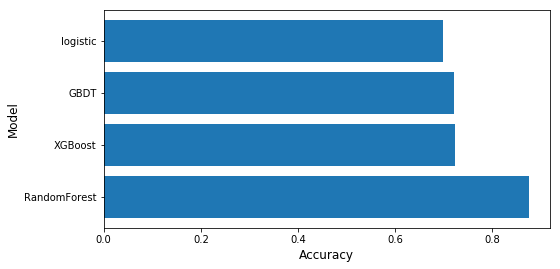

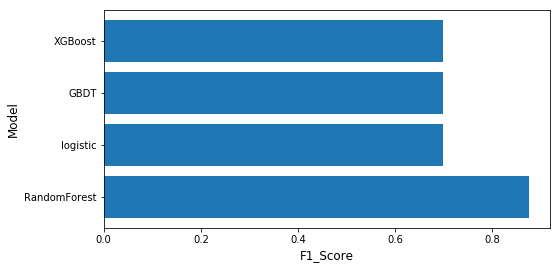

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# WEB Funtion
def draw_from_dict(dicdata, RANGE, heng=0):
    by_value = sorted(dicdata.items(),key = lambda item:item[1],reverse=True)
    x = []
    y = []
    plt.figure(figsize=(16, 8), dpi=80)
    for d in by_value:
        x.append(d[0])
        y.append(d[1])
    plt.grid()
    plt.ylabel('Total flight numbers', size=16)
    plt.xlabel('Arrival airport', size=16)
    plt.xticks(rotation = 90)
    # plt.bar(x[0:RANGE], y[0:RANGE])
    sns.barplot(x=x[0:RANGE], y=y[0:RANGE], label='Number of Flights')
    plt.legend()
    plt.show()


def airport_statistics(airport, start_date, end_date):
    # Get airport data
    airport_data = flight_weather[flight_weather['departure_iata'] == airport]
    
    # Get data from assigned date
    start_index = airport_data[airport_data['flight_date'] == start_date].index.tolist()[0] 
    end_index = airport_data[airport_data['flight_date'] == end_date].index.tolist()[0] 
    airport_date = airport_data.loc[start_index : end_index, :]
    
    # Draw departure_arrival statics
    arrival_airport = airport_date['arrival_iata'].value_counts().to_dict()
    draw_from_dict(arrival_airport, len(arrival_airport))

    # Delay minutes
    delay_minutes = airport_date.groupby('flight_date').mean()['departure_delay']
    delay_data = airport_date['flight_date'].unique()
    plt.figure(figsize=(8, 4),  dpi=80)
    plt.xlabel('flight date')
    plt.ylabel('delay minutes')
    plt.xticks(rotation = 45)
    plt.plot(delay_data, delay_minutes, linewidth=4, color = '#EE7621', label='delay minutes')
    plt.legend()
    plt.grid()
    plt.show()
    
    df = airport_date['flight_status'].value_counts()
    y = df.values
    plt.figure(figsize=(14, 7))
    explode = []
    if len(df.keys()) == 5:
        explode = [0.2, 0, 0, 0, 0]
    else:
        explode = [0.2, 0, 0, 0, 0, 0]
    plt.pie(y,
            labels=df.keys().to_list(),
            colors=["skyblue", "red", "green", "purple", "pink", "yellow"], 
            shadow = True,
            explode= explode,
            autopct='%.2f%%', 
           )
    plt.show()
    
    by_value = sorted(accuracy_score.items(),key = lambda item:item[1],reverse=True)
    x = []
    y = []
    plt.figure(figsize=(8, 4))
    for d in by_value:
        x.append(d[0])
        y.append(d[1])
    
    plt.ylabel('Model', size=12)
    plt.xlabel('Accuracy', size=12)
    plt.xticks()
    plt.barh(x[0:len(accuracy_score)], y[0:len(accuracy_score)])
    plt.show()
    
    by_value = sorted(f1_scores.items(),key = lambda item:item[1],reverse=True)
    x = []
    y = []
    plt.figure(figsize=(8, 4))
    for d in by_value:
        x.append(d[0])
        y.append(d[1])
    
    plt.ylabel('Model', size=12)
    plt.xlabel('F1_Score', size=12)
    plt.xticks()
    plt.barh(x[0:len(f1_scores)], y[0:len(f1_scores)])
    plt.show()
    
    
    

    
    pass
    # return airport_date

airport_statistics('ATL', '2021-12-06', '2022-02-26')